In [1]:
import os
import json
import uuid
from workflow_manager import WorkflowManager, MongoWorkflow

In [2]:
# Load the sample input json for the request
example_file = os.path.join(".", "workflow_input_example.txt")
with open(example_file) as f:
    input_json = json.load(f)
#input_json

In [3]:
%%time
# Initialize the workflow class object and inputs
sim_id = str(uuid.uuid4())
debug = True
local = True
workflow = WorkflowManager(
    task_id=sim_id,
    sim_input=input_json["sim_input"],
    order=input_json["network"]["order"],
    sources=input_json["network"]["sources"],
    local=local,
    debug=debug
)
workflow.task_id

Wall time: 5.02 s


'6caa1731-5e94-4648-a5ab-15d9abb1bfce'

In [4]:
workflow.scheduler

LocalCluster(5cdb3986, 'tcp://127.0.0.1:63407', workers=4, threads=16, memory=127.76 GiB)

In [5]:
%%time
#TODO: Specify simulation level dependency tasks.
# input_json["simulation_dependencies"] = [{'name': NAME, 'url': URL, 'input': INPUT}]
# These dependencies will correspond to data retrieval tasks, performed by the Workflow manager prior to simulation execution tasks, to the HMS backend
# The results of these dependency tasks are stored in mongoDB by taskID, then passed along in the AQT workflow tasks by id
# The backend will be responsible for the logic and handling of the data
# When the backend merges the data into input (which will need to occur prior to merging the upstream segments) the backend will then save the 
# updated input (for potential reuse)

workflow.define_presim_dependencies(input_json["simulation_dependencies"])

Wall time: 0 ns


In [6]:
%%time
# Construct the dask graph from the catchment list
# Catchment dependencies behave the same way as simulation dependencies, but are only passed to the corresponding segment task and have the appropriate linking.
workflow.construct(input_json["comid_inputs"], input_json["catchment_dependencies"])

Wall time: 406 ms


6177452 : {}
6177450 : {}
6177476 : {'6177452': '4b253404-8178-4d12-bdd6-2031750486bf', '6177450': '8a5bc0fe-68f0-4e14-a5cf-66fba044c056'}
6177474 : {}
6177558 : {'6177476': '9cd56ab3-edcd-4584-b55e-6d86ddede640', '6177474': 'e8352400-f7f1-43cc-b3bd-deb1a44a65d6'}
Delayed('6177558_18f1e4eb-55aa-4191-b358-33d305fe826a')


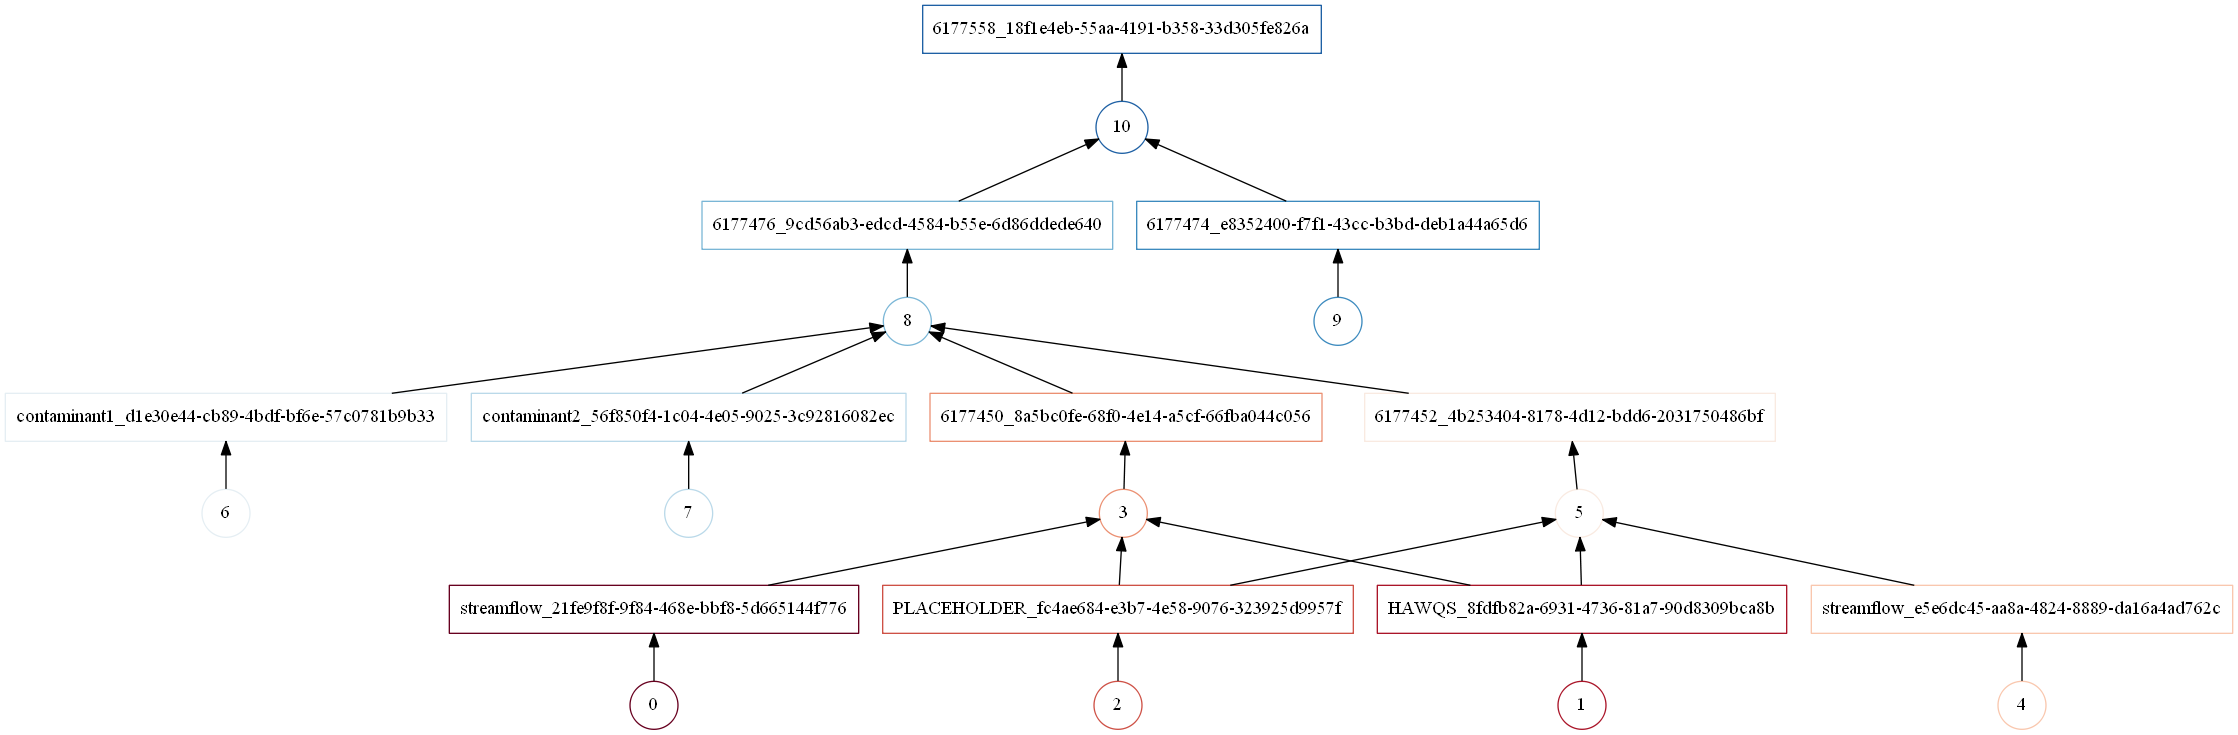

In [7]:
[print(f"{comid} : {c_id}") for comid, c_id in workflow.source_ids.items()]
print(workflow.pourpoint)
workflow.pourpoint.visualize("workflow-graph.png", color='order', verbose=True)

In [8]:
[print(f"{comid} : {c_id}") for comid, c_id in workflow.catchment_ids.items()]

6177452 : 4b253404-8178-4d12-bdd6-2031750486bf
6177450 : 8a5bc0fe-68f0-4e14-a5cf-66fba044c056
6177476 : 9cd56ab3-edcd-4584-b55e-6d86ddede640
6177474 : e8352400-f7f1-43cc-b3bd-deb1a44a65d6
6177558 : 18f1e4eb-55aa-4191-b358-33d305fe826a


[None, None, None, None, None]

In [11]:
%%time
# Request to get the simulation status from mongoDB
sim_status = MongoWorkflow.get_status(task_id=sim_id)
del sim_status["input"]
sim_status

Wall time: 110 ms


{'_id': '6caa1731-5e94-4648-a5ab-15d9abb1bfce',
 'type': 'workflow',
 'status': 'COMPLETED',
 'update_time': '2021-05-21 10:24:12.050613',
 'message': None,
 'catchments': {'6177452': {'status': 'COMPLETED',
   'task_id': '4b253404-8178-4d12-bdd6-2031750486bf',
   'message': None,
   'update_time': '2021-05-21 10:23:50.206383',
   'dependencies': {'streamflow': 'e5e6dc45-aa8a-4824-8889-da16a4ad762c'}},
  '6177450': {'status': 'COMPLETED',
   'task_id': '8a5bc0fe-68f0-4e14-a5cf-66fba044c056',
   'message': None,
   'update_time': '2021-05-21 10:23:50.214123',
   'dependencies': {'streamflow': '21fe9f8f-9f84-468e-bbf8-5d665144f776'}},
  '6177476': {'status': 'COMPLETED',
   'task_id': '9cd56ab3-edcd-4584-b55e-6d86ddede640',
   'message': None,
   'update_time': '2021-05-21 10:24:00.985107',
   'dependencies': {'contaminant1': 'd1e30e44-cb89-4bdf-bf6e-57c0781b9b33',
    'contaminant2': '56f850f4-1c04-4e05-9025-3c92816082ec'}},
  '6177474': {'status': 'COMPLETED',
   'task_id': 'e8352400-f

In [10]:
%%time
# Executes the workflow, based upon the constructed graph
workflow.compute()

Wall time: 42.9 s


In [13]:
%%time
# Get the catchment status from mongoDB
catchment_id = "6fbbb028-96e1-4ed6-a1ec-091a2ce853e9"
catchment_status = MongoWorkflow.get_status(task_id=catchment_id)
del catchment_status["input"]
catchment_status

Wall time: 53.9 ms


{'_id': '6fbbb028-96e1-4ed6-a1ec-091a2ce853e9',
 'type': 'catchment',
 'sim_id': '95b07c78-57c5-4f11-b26b-cde8e7fa9be6',
 'status': 'FAILED',
 'update_time': '2021-05-21 10:21:02.492220',
 'message': "'metadata'",
 'upstream': {},
 'dependencies': {'streamflow': 'd2d6ae30-3724-40ca-8acb-680f05c10ee5'},
 'runtime': '10.3635'}

In [16]:
%%time
# Get the catchment data from mongoDB
catchment_data = MongoWorkflow.get_data(task_id=catchment_id)


Wall time: 34.2 ms
